In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [328]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import starry
from scipy.special import legendre as P

starry.config.quiet = True

In [396]:
ydeg = 20
map = starry.Map(ydeg, lazy=False)

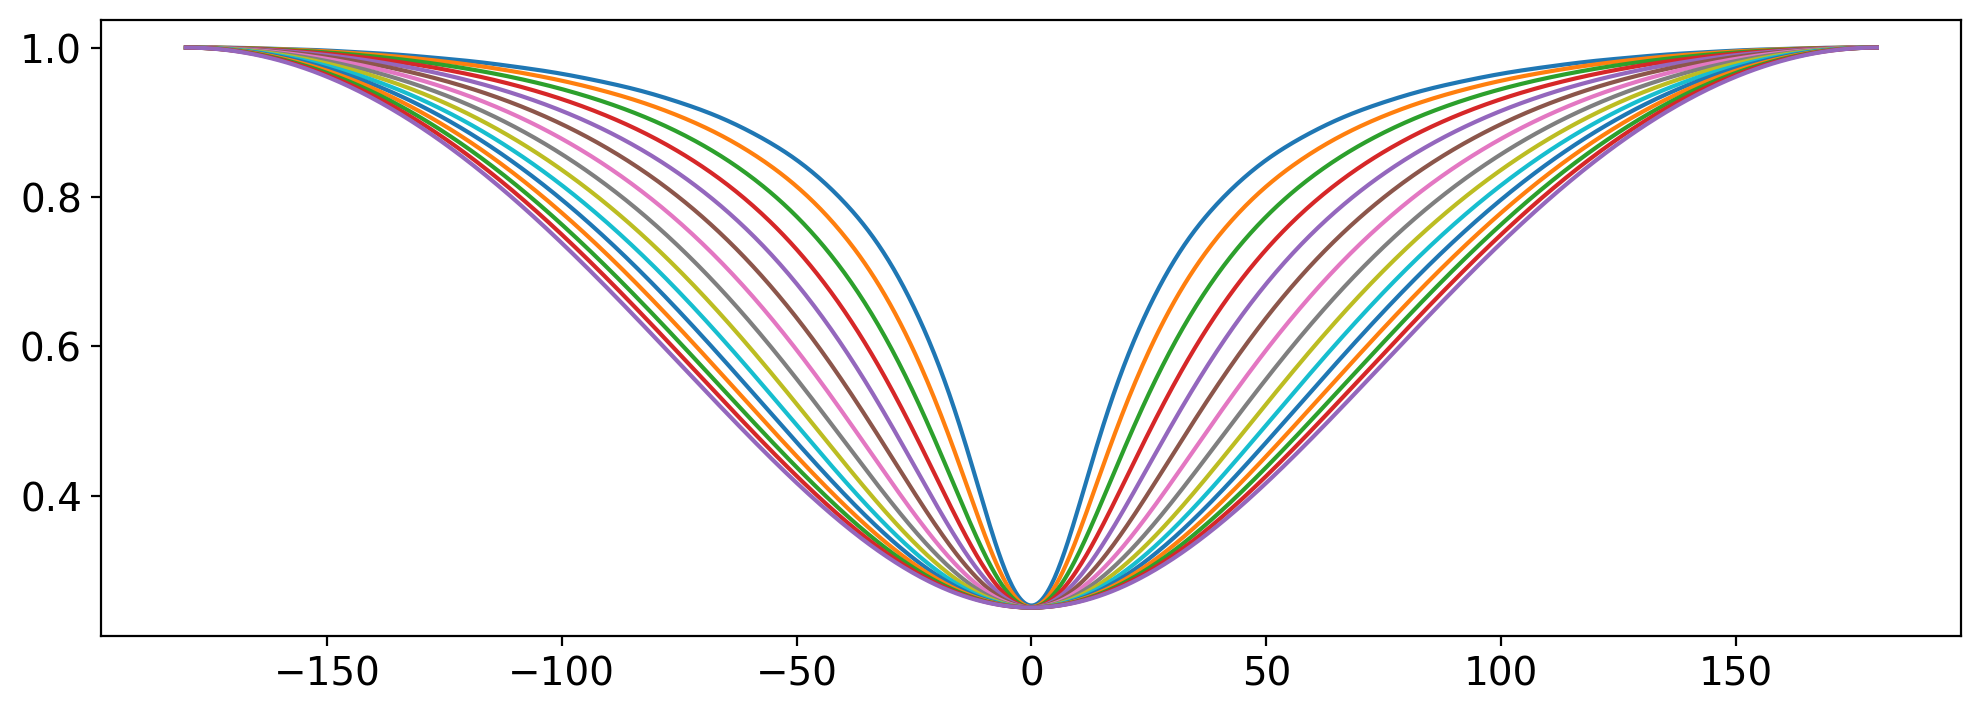

In [397]:
cr = np.logspace(-0.5, 1, 15)
delta = 0.75
lon = np.linspace(-180, 180, 1000)
l = np.arange(1, map.ydeg + 1)

fig, ax = plt.subplots(1, figsize=(12, 4))
for k in range(len(cr)):
    
    x = np.zeros(map.Ny)
    x[0] = 1 - 0.5 * delta * cr[k] * (1 + cr[k]) ** -1
    x[l * (l + 1)] = -delta / np.sqrt(2 * l + 1) * (
        (1 + cr[k]) ** -(l + 1) * cr[k]
        +
        0.5 * (1 + cr[k]) ** -(l + 1) * cr[k] ** 2
    )
    
    map[:, :] = x
    ax.plot(lon, np.pi * map.intensity(lon=lon));

In [356]:
def is_monotonic(ydeg, cr, npts=10000):
    theta = np.linspace(0, np.pi, npts)
    cost = np.cos(theta)
    I = (1 - 0.5 * delta * cr / (1 + cr)) * P(0)(cost)
    for l in range(1, ydeg + 1):
        I -= 0.5 * delta * cr * (2 + cr) / (1 + cr) ** (l + 1) * P(l)(cost)
    return np.all(np.gradient(I) >= 0)

In [364]:
ydeg = 10

def min_radius(ydeg, tol=1e-6, upper_bound=10, maxiter=100):
    tol = 1e-6
    bounds = [0, upper_bound]
    k = 0
    while np.abs(np.diff(bounds)) > tol:
        mid = 0.5 * (bounds[0] + bounds[1])
        if is_monotonic(ydeg, mid):
            bounds = [bounds[0], mid]
        else:
            bounds = [mid, bounds[1]]
        k += 1
        if k > maxiter:
            raise ValueError("Solver did not converge.")
    return bounds[0]

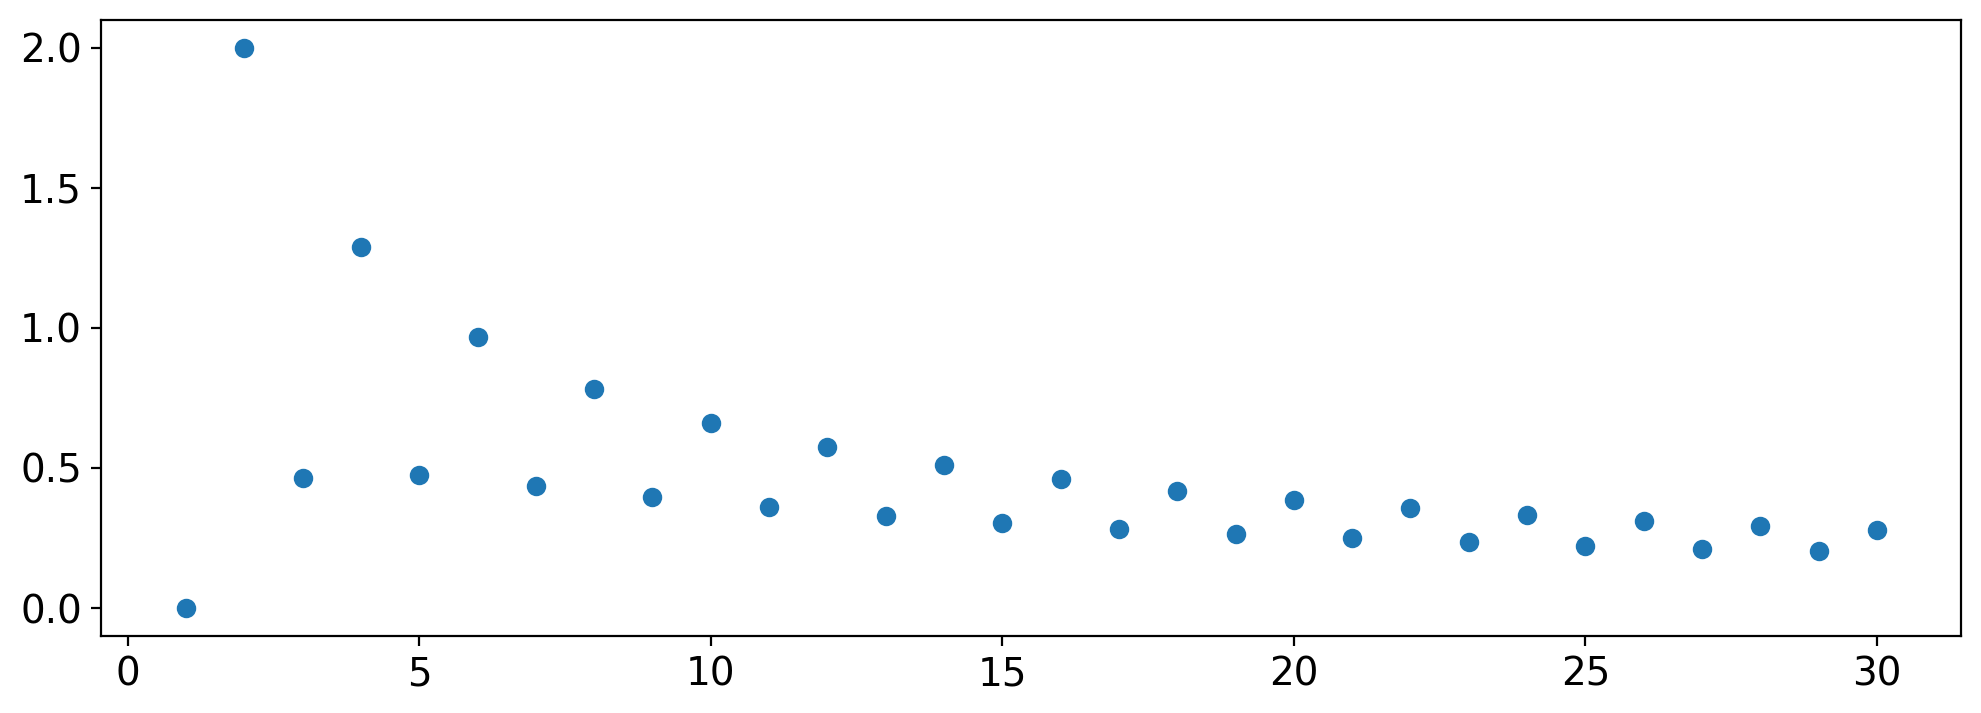

In [406]:
l = np.arange(1, 31, dtype=int)
r = np.zeros_like(l, dtype=float)
for i in range(len(l)):
    r[i] = min_radius(l[i])
plt.plot(l, r, "o")